In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [2]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [3]:
RANDOM_SEED = 42

In [4]:
!pip freeze > requirements.txt

In [5]:
pd.options.mode.chained_assignment = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


# Дата сет

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [6]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print(df_train.shape)
display(df_train.sample(10))
print(df_test.shape)
display(df_test.sample(10))

(73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
43620,58286,06MAR2014,GRD,F,51,Y,Y,0,1,-2.503139,6,80,2,3,190000,1,4,Y,0
49092,1836,06JAN2014,SCH,M,25,Y,N,0,1,-2.344380,0,50,1,3,35000,1,4,N,0
38227,90369,07APR2014,SCH,F,56,N,N,0,0,-1.946948,2,50,2,3,30000,1,3,N,0
16461,40689,17FEB2014,GRD,F,56,N,N,2,0,-1.549614,3,80,2,3,15000,1,3,N,0
35981,77145,25MAR2014,GRD,F,49,N,N,0,0,-2.900383,1,60,2,3,60000,1,4,Y,0
47052,91549,08APR2014,SCH,M,42,Y,N,0,0,-1.060340,2,80,2,3,32000,4,2,N,1
67925,32955,09FEB2014,GRD,M,34,N,N,0,0,-2.138247,3,50,2,3,45000,1,2,N,1
23981,68086,17MAR2014,SCH,M,43,N,N,0,0,-2.718091,4,50,2,3,50000,1,1,N,0
9816,53153,02MAR2014,SCH,M,29,N,N,0,0,-2.186512,0,50,1,2,17000,1,3,N,0
25072,5681,12JAN2014,SCH,F,37,N,N,0,0,-1.768261,2,40,1,2,11700,2,3,N,0


(36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
17955,42458,19FEB2014,SCH,M,45,Y,N,0,1,-2.056565,0,60,1,2,60000,2,3,N
20662,100427,17APR2014,SCH,M,24,N,N,0,0,-2.143180,1,40,2,1,40000,2,2,N
33200,50726,27FEB2014,UGR,F,37,N,N,0,1,-1.716362,0,40,2,3,22000,2,1,N
7731,110015,30APR2014,GRD,F,27,N,N,0,0,-1.492127,3,50,2,3,40000,1,4,N
12427,43179,19FEB2014,SCH,M,29,N,N,1,0,-1.535336,9,80,2,3,55000,1,3,N
22469,68074,17MAR2014,SCH,F,41,N,N,0,0,-1.068170,6,50,2,3,45000,4,3,N
639,47096,24FEB2014,SCH,M,31,N,N,1,0,-1.865541,3,60,1,2,39000,2,1,N
10799,62720,12MAR2014,PGR,M,49,Y,Y,0,0,-2.249240,1,80,2,3,47000,1,3,N
24769,104551,23APR2014,PGR,M,25,N,N,2,0,-2.358861,1,60,1,2,25000,2,1,N
9339,50897,27FEB2014,SCH,M,64,Y,N,0,0,-0.989109,1,60,1,1,45000,1,3,N


In [7]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [8]:
df_train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [9]:
df_test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Видно, что есть пропуски в education, столбец с датами необходимо привести в читаемый вид

In [10]:
df_train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

# Функции

In [11]:

def uniq_nan (df,c):
# Уникальные значения, пропущенные значения 
    column_type_numeric = False
    # тип колонки
    if df[c].dtype == 'O':
        print("Столбец:", c, "не является числовым")
    elif df[c].dtype == "int64" or df[c].dtype == "float64":
        column_type_numeric = True        
        print("Столбец:", c, "является числовым")
    else:
        print('Признак', c, 'имеет тип', df[c].dtype)
    #print("Столбец:", c)    
    print(pd.DataFrame(df[c].unique()))    
    print("Пропущено значений:", df[c].isna().sum())
    print(df[c].value_counts())
    


# **Предобработка данных**

## 1. Преобразование столбца с датами

In [12]:
df_train.app_date = pd.to_datetime(df_train.app_date, format='%d%b%Y')
df_test.app_date = pd.to_datetime(df_test.app_date, format='%d%b%Y')
print(df_train.app_date.sample(5))
print(df_test.app_date.sample(5))

58033   2014-01-17
20867   2014-02-07
20790   2014-03-27
49183   2014-01-15
19970   2014-03-12
Name: app_date, dtype: datetime64[ns]
32926   2014-04-01
26048   2014-03-06
22849   2014-01-25
31424   2014-04-04
12583   2014-01-26
Name: app_date, dtype: datetime64[ns]


Создание новго признака на основе столбца с датами

Находим начало и конец временного отрезка дата сета

In [13]:
start_tr = df_train.app_date.min()
end_tr = df_train.app_date.max()
start_tr,end_tr

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [14]:
# Количество дней от старта заявки 
df_train['day_num'] = df_train.app_date - df_train.app_date.min()
df_train['day_num'] = df_train['day_num'].apply(lambda x: str(x).split()[0])
df_train['day_num'] = df_train['day_num'].astype(int)

In [15]:
# Количество дней от старта заявки 
df_test['day_num'] = df_test.app_date - df_test.app_date.min()
df_test['day_num'] = df_test['day_num'].apply(lambda x: str(x).split()[0])
df_test['day_num'] = df_test['day_num'].astype(int)

In [16]:
# Теперь столбец с датой можно удалить
df_test = df_test.drop(columns = ['app_date'])
df_train = df_train.drop(columns = ['app_date'])

## 2. Работа с пропусками

In [17]:
# Работа с пропусками

In [18]:
uniq_nan(df_train, 'education')

Столбец: education не является числовым
     0
0  SCH
1  GRD
2  UGR
3  PGR
4  ACD
5  NaN
Пропущено значений: 307
SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64


In [19]:
#Решено заполнить значением "unknown"
df_train['education'] = df_train['education'].fillna('unknown')
df_test['education'] = df_test['education'].fillna('unknown')

### Преобразование признака в числовой формат

In [20]:
def educ(x):
    if x == 'SCH':
        return 1
    elif x == 'GRD':
        return 2
    elif x == 'UGR':
        return 3
    elif x == 'PGR':
        return 4
    elif x == 'unknown':
        return 5
    elif x == 'ACD':
        return 6

df_train['education'] = df_train['education'].apply(educ)
df_test['education'] = df_test['education'].apply(educ)

In [21]:
df_train.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,day_num
36082,70545,1,F,59,N,N,0,0,-1.781642,2,60,2,3,16000,1,3,N,0,76
64806,14017,1,F,45,N,N,0,0,-1.436892,0,80,2,3,120000,1,3,N,0,20
30220,75153,2,F,56,N,N,1,0,-1.376231,1,80,2,3,13000,1,3,Y,0,80
50234,92467,1,F,61,N,N,0,0,-1.660604,2,50,2,3,15000,1,2,N,0,97
59184,41553,1,M,26,N,N,0,0,-1.395963,0,50,2,3,27000,1,1,N,0,48


In [76]:
# Сохрания ID клиентов из тестового набора для последующего формирования Submission
id_test = df_test.client_id

### Разделим данные на группы переменных:  

In [22]:
time_cols = ['app_date'] # временная переменная
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # бинарные переменные (default - целевой признак, не включаем в список)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time'] # категориальные переменные
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','day_num'] # числовые переменные

### Числовые переменные

Text(0.5, 1.0, 'Histogram for default')

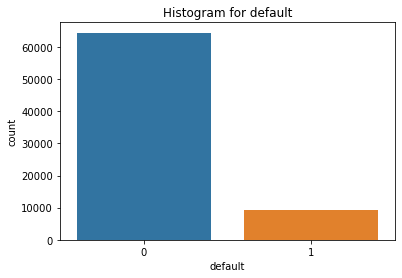

In [23]:
# Целевая переменная
sns.countplot(df_train.default)
plt.title('Histogram for default')

По данным графика видно, что результаты разделены неравномерно. Недефолтных клиентов больше

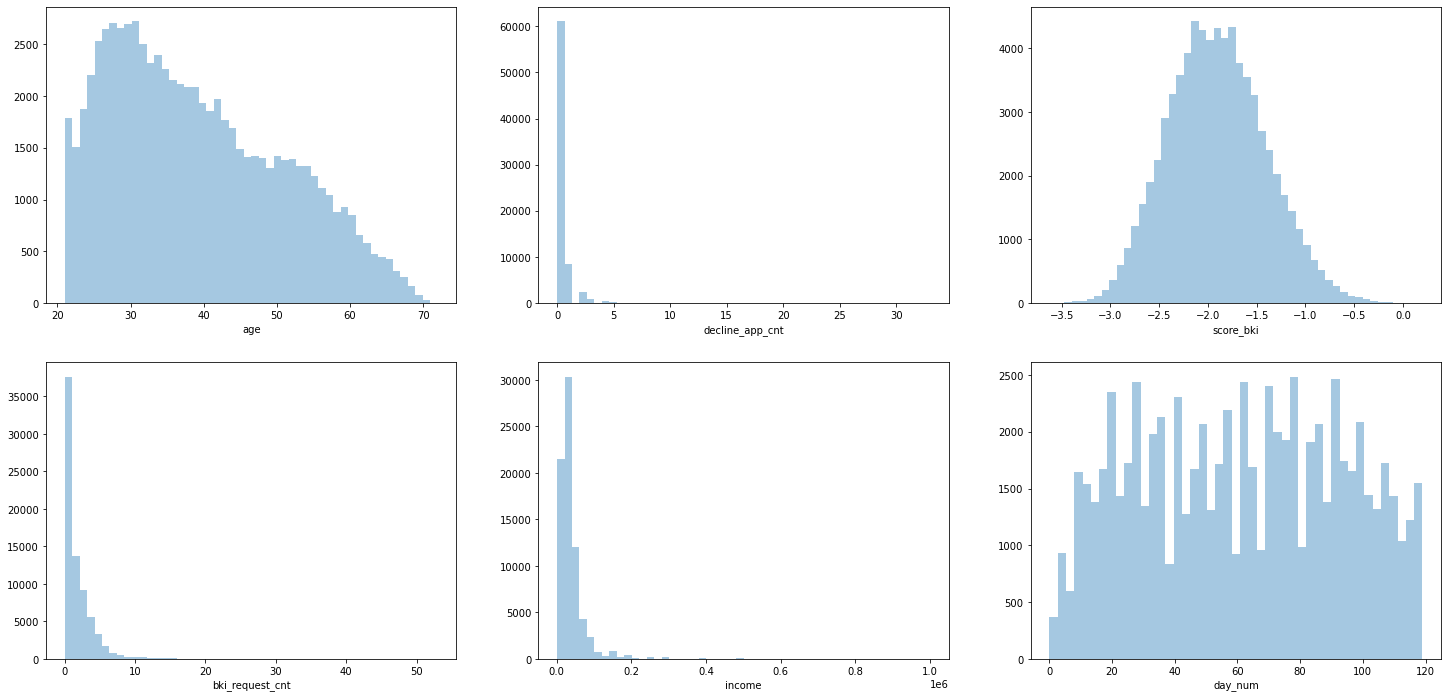

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(df_train[col], kde=False, ax=axes.flat[i])

После построения гистограмм видно, что распределения всех числовых неравномерно. На нормальное распределение похоже score_bki 


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


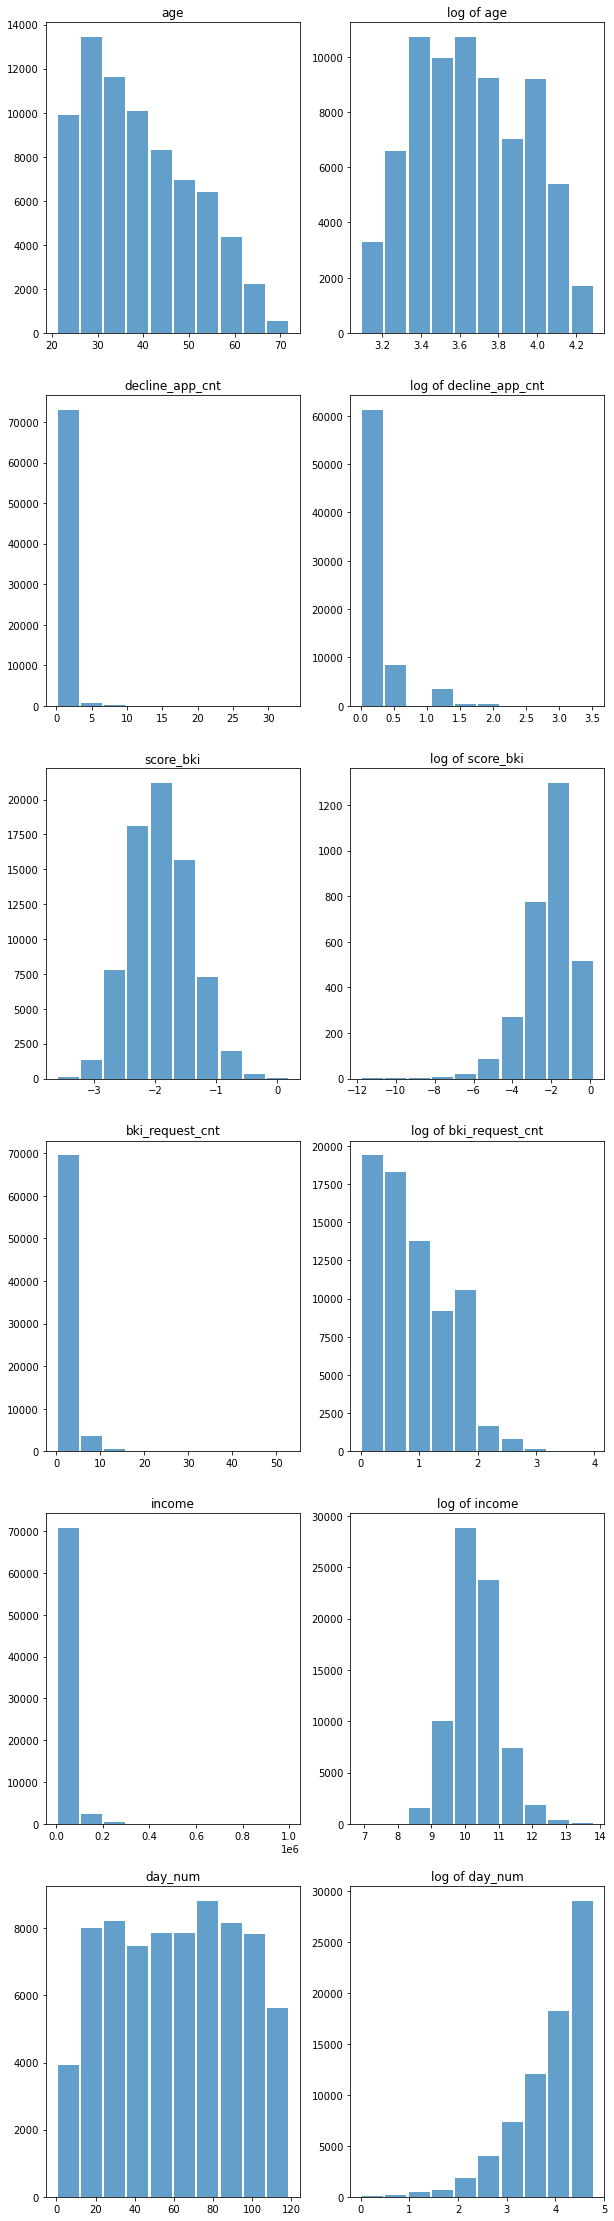

In [25]:
#Изобразим графики значений и логарима значений
fig, ax = plt.subplots(len(num_cols), 2, figsize=(10, 40))

for x in range(len(num_cols)):
    new_series_log = np.log(df_train[num_cols[x]] + 1)
    
    ax[x, 0].hist(df_train[num_cols[x]], rwidth=0.9, alpha=0.7)
    ax[x, 0].set_title(num_cols[x])
    
    ax[x, 1].hist(new_series_log, rwidth=0.9, alpha=0.7)
    ax[x, 1].set_title('log of ' + num_cols[x])

In [79]:
# На основании графиков можно сделать следующие преобразования:

df_train['age'] = np.log(df_train['age'] + 1)
df_train['decline_app_cnt'] = np.log(df_train['decline_app_cnt'] + 1)
df_train['bki_request_cnt'] = np.log(df_train['bki_request_cnt'] + 1)
df_train['income'] = np.log(df_train['income'] + 1)
df_train['day_num'] = np.log(df_train['day_num'] + 1)

df_test['age'] = np.log(df_test['age'] + 1)
df_test['decline_app_cnt'] = np.log(df_test['decline_app_cnt'] + 1)
df_test['bki_request_cnt'] = np.log(df_test['bki_request_cnt'] + 1)
df_test['income'] = np.log(df_test['income'] + 1)
df_test['day_num'] = np.log(df_test['day_num'] + 1)

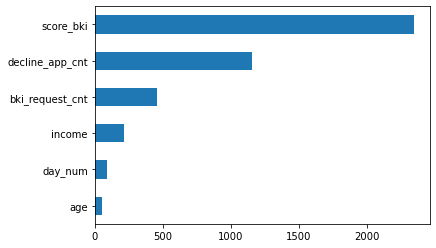

In [27]:
imp_num = Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


самый значимый из числовых признаков score_bki (оценка плательщика БКИ), на втором месте declain_app_cnt (кол-во отказанных заявок), наименее значимый признак age

# Оценка корреляции признаков

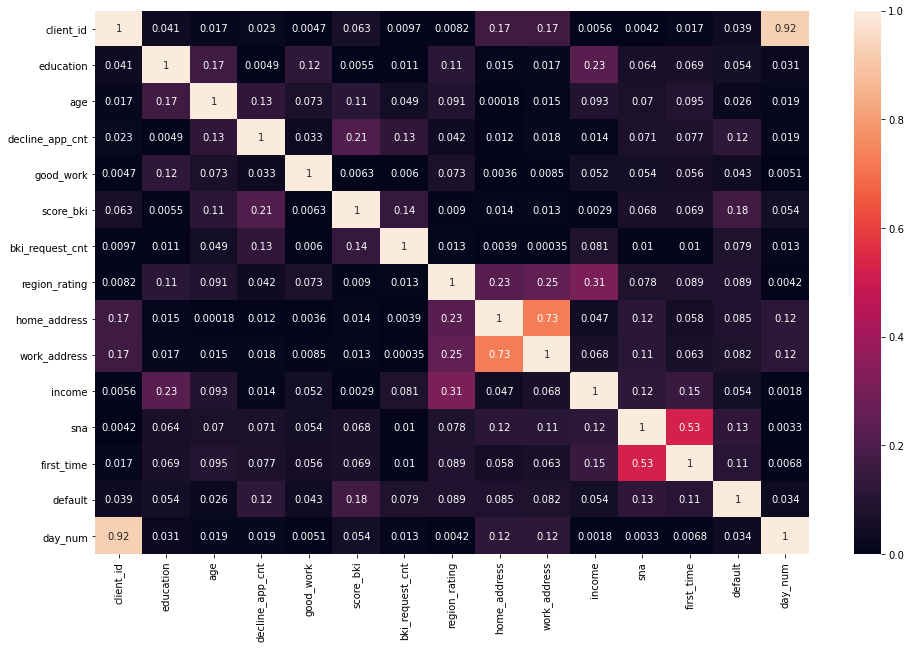

In [28]:
plt.figure(figsize=(16,10))
sns.heatmap(df_train.corr().abs(), vmin=0, vmax=1, annot=True)

По данным графика можем сделать вывод о независимости переменных

## Бинарные и категориальные переменные

Преобразование бинарных переменных с помощью LabelEncoder

In [29]:

label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

    
# убедимся в преобразовании    
display(df_train.head())
display(df_test.head())

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,day_num
0,25905,1,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,3.465736
1,63161,1,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,4.262680
2,25887,1,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,3.465736
3,16222,1,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,3.135494
4,101655,2,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,4.682131


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,day_num
0,74835,2,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,80
1,17527,1,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,23
2,75683,3,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,81
3,26883,1,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,33
4,28862,2,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,34


Преобразование категориальных переменных с помощью OneHotEncoder

In [30]:
x_cat = OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(df_test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(73799, 27)
(36349, 27)


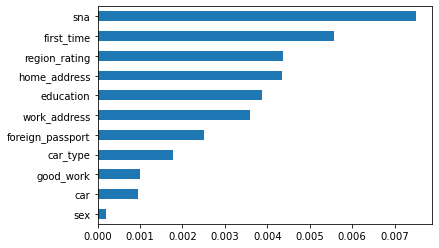

In [31]:
# Значимость признаков

imp_cat = Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Исходя из графика можно сделать вывод о малозначимости признака sex и высокой значимости sna

# Подготовка данных к машинному обучению¶


In [77]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df_train[num_cols].values)
X_num_test = StandardScaler().fit_transform(df_test[num_cols].values)

In [78]:
X = np.hstack([X_num, df_train[bin_cols].values, x_cat])
Y = df_train['default'].values
Test = np.hstack([X_num_test, df_test[bin_cols].values, y_cat])

id_test = df_test.client_id

In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   education         36349 non-null  int64  
 2   sex               36349 non-null  int64  
 3   age               36349 non-null  int64  
 4   car               36349 non-null  int64  
 5   car_type          36349 non-null  int64  
 6   decline_app_cnt   36349 non-null  int64  
 7   good_work         36349 non-null  int64  
 8   score_bki         36349 non-null  float64
 9   bki_request_cnt   36349 non-null  int64  
 10  region_rating     36349 non-null  int64  
 11  home_address      36349 non-null  int64  
 12  work_address      36349 non-null  int64  
 13  income            36349 non-null  int64  
 14  sna               36349 non-null  int64  
 15  first_time        36349 non-null  int64  
 16  foreign_passport  36349 non-null  int64 

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_test.shape

(14760, 38)

# Модель


In [56]:
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
Y_predicted = model.predict(X_test)
print('accuracy_score:',accuracy_score(y_test,Y_predicted))
print('precision_score:',precision_score(y_test,Y_predicted))
print('recall_score:',recall_score(y_test,Y_predicted))
print('f1_score:',f1_score(y_test,Y_predicted))
print('MAE:', metrics.mean_absolute_error(y_test,Y_predicted))

accuracy_score: 0.8746612466124661
precision_score: 0.37894736842105264
recall_score: 0.019704433497536946
f1_score: 0.03746097814776275
MAE: 0.12533875338753386


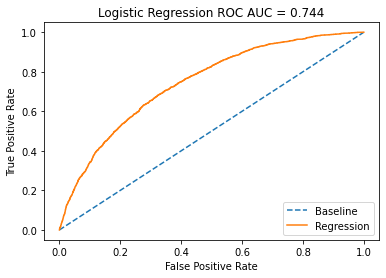

In [58]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Подбор гиперпараметров¶

In [59]:
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=12, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6707
Precision: 0.2267
Recall: 0.6886
F1: 0.3411


In [60]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= 12, 
                           penalty= 'none', 
                           solver = 'saga', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.6707
Precision: 0.2267
Recall: 0.6886
F1: 0.3411


In [68]:
len(y_pred_prob)
len(id_test)

36349

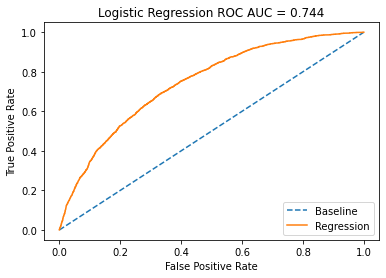

In [61]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [80]:

submission_pred_prob = model.predict_proba(Test)[:,1]
submission_predict = model.predict(Test)

submission = pd.DataFrame({'client_id': id_test, 
                            'default': submission_pred_prob})
submission.to_csv('submission.csv', index=False)

submission

,client_id,default
0,74835,0.200587
1,17527,0.814750
2,75683,0.305876
3,26883,0.404654
4,28862,0.147352
...,...,...
36344,83775,0.744671
36345,106254,0.117721
36346,81852,0.773582
36347,1971,0.575796


> 